In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    roc_curve,
    auc
)
from sklearn.model_selection import KFold


In [2]:
ds_dir = '../Datasets/5-classes'
img_height = 256
img_width = 256

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Train',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Train')),
    image_size=(img_height, img_width)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Val',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Val')),
    image_size=(img_height, img_width)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Test',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Test')),
    image_size=(img_height, img_width)
)

Found 2020 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 1035 files belonging to 5 classes.


In [4]:
for x, y in train_ds:
    x_train = x.numpy()
    y_train = y.numpy()

for x, y in validation_ds:
    x_val = x.numpy()
    y_val = y.numpy()

for x, y in test_ds:
    x_test = x.numpy()
    y_test = y.numpy()

# x_train = np.concatenate((x_train, x_val), axis=0)
# y_train = np.concatenate((y_train, y_val), axis=0)


In [5]:
y_train

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [6]:
normalize = lambda ds: ds / 255 - 0.5

x_train = normalize(x_train)
x_val = normalize(x_val)
x_test = normalize(x_test)

In [7]:
flatten = lambda ds: ds.reshape((-1, ds.shape[1] ** 2))

print(x_train.shape)
print(x_test.shape)

x_train = flatten(x_train)
x_val = flatten(x_val)
x_test = flatten(x_test)

print(x_train.shape)
print(x_test.shape)

(2020, 256, 256, 1)
(1035, 256, 256, 1)
(2020, 65536)
(1035, 65536)


### Summary

In [8]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2097184   
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 32)                288       
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,097,901
Trainable params: 2,097,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    x_train, y_train,
    batch_size=128,
    validation_split=0.33,
    epochs=20,
    verbose=1
)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
11/11 [==============================] - 1s 58ms/step - loss: 1.5673 - accuracy: 0.2343 - val_loss: 1.5402 - val_accuracy: 0.2639
Epoch 2/20
11/11 [==============================] - 0s 36ms/step - loss: 1.5121 - accuracy: 0.3200 - val_loss: 1.5052 - val_accuracy: 0.3988
Epoch 3/20
11/11 [==============================] - 1s 48ms/step - loss: 1.4748 - accuracy: 0.5018 - val_loss: 1.4755 - val_accuracy: 0.5007
Epoch 4/20
11/11 [==============================] - 0s 38ms/step - loss: 1.4392 - accuracy: 0.5432 - val_loss: 1.4249 - val_accuracy: 0.5367
Epoch 5/20
11/11 [==============================] - 0s 37ms/step - loss: 1.4009 - accuracy: 0.5654 - val_loss: 1.3940 - val_accuracy: 0.5352
Epoch 6/20
11/11 [==============================] - 0s 40ms/step - loss: 1.3591 - accuracy: 0.5831 - val_loss: 1.3637 - val_accuracy: 0.5577
Epoch 7/20
11/11 [==============================] - 0s 42ms/step - loss: 1.3141 - accuracy: 0.6179 - val_loss: 1.3146 - val_accuracy: 0.5697
Epoch 8/20
11

In [11]:
def generate_actual_predicted(model, X_test, Y_test):
    Y_pred = model.predict(X_test)

    predicted = []
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
    
    actual = []
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
    
    return actual, predicted

actual, predicted = generate_actual_predicted(model, x_test, y_test)

### Evaluation Metrics

In [12]:
print(confusion_matrix(actual,predicted))
print(accuracy_score(actual, predicted))

[[120   4   1   8  74]
 [128  17  16  18  28]
 [  4   8 178  16   1]
 [ 12  16 112  65   2]
 [ 57   7   0   2 141]]
0.5033816425120773


In [13]:
print(f1_score(actual, predicted, average='macro'))
print(precision_score(actual, predicted, average='macro'))
print(recall_score(actual, predicted, average='macro'))

0.46246711021306364
0.4900120839642545
0.5033816425120773


In [14]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.37      0.58      0.45       207
           1       0.33      0.08      0.13       207
           2       0.58      0.86      0.69       207
           3       0.60      0.31      0.41       207
           4       0.57      0.68      0.62       207

    accuracy                           0.50      1035
   macro avg       0.49      0.50      0.46      1035
weighted avg       0.49      0.50      0.46      1035



### Accuracy Curve

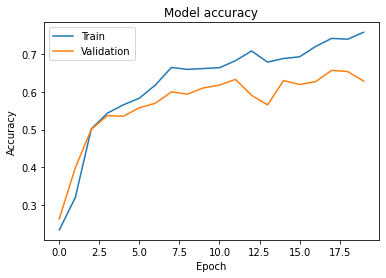

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Loss Curve

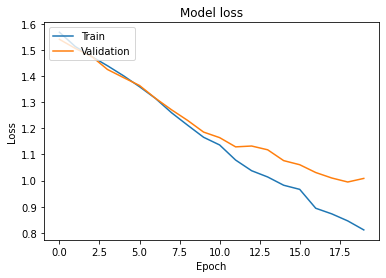

In [16]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

### K-Fold

In [17]:
def create_model():
    model = Sequential()
    model.add(Dense(8, input_dim=x_train.shape[1],activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model


In [ ]:
n_folds=10

results = []


x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
# print(x_train_val.shape)
# print(y_train_val.shape)

# print(f'y_train_val is one-hot-encoded: {(y_train_val.sum(axis=1)-np.ones(y_train_val.shape[0])).sum()==0}')

In [18]:
for train_index, test_index in KFold(n_folds).split(x_train_val):
    x_tr, x_ts = x_train_val[train_index], x_train_val[test_index]
    y_tr, y_ts = y_train_val[train_index], y_train_val[test_index]
    
    model = create_model()
    model.fit(x_tr, y_tr, epochs=30)
    
    scores = model.evaluate(x_test,y_test)

    for i,names in zip(np.arange(0, len(model.metrics_names)), model.metrics_names):
        print(model.metrics_names[i],'=',scores[i])

    actual, predicted = generate_actual_predicted(model, x_ts, y_ts)

    precision = precision_score(actual, predicted, average='macro')
    recall = recall_score(actual, predicted, average='macro')
    f1 = f1_score(actual, predicted, average='macro')

    print('precision', precision)
    print('recall', recall)
    print('F1-Score', f1)

    results.append([precision, recall, f1])

Epoch 1/30
71/71 [==============================] - 1s 7ms/step - loss: 1.6869 - accuracy: 0.2725
Epoch 2/30
71/71 [==============================] - 1s 9ms/step - loss: 1.4698 - accuracy: 0.3276
Epoch 3/30
71/71 [==============================] - 1s 8ms/step - loss: 1.4290 - accuracy: 0.3580
Epoch 4/30
71/71 [==============================] - 1s 8ms/step - loss: 1.3756 - accuracy: 0.4070
Epoch 5/30
71/71 [==============================] - 1s 8ms/step - loss: 1.3113 - accuracy: 0.4303
Epoch 6/30
71/71 [==============================] - 1s 8ms/step - loss: 1.2854 - accuracy: 0.4317
Epoch 7/30
71/71 [==============================] - 1s 8ms/step - loss: 1.2593 - accuracy: 0.4343
Epoch 8/30
71/71 [==============================] - 1s 9ms/step - loss: 1.2401 - accuracy: 0.4321
Epoch 9/30
71/71 [==============================] - 1s 8ms/step - loss: 1.2137 - accuracy: 0.4449
Epoch 10/30
71/71 [==============================] - 1s 8ms/step - loss: 1.2285 - accuracy: 0.4392
Epoch 11/30
71/71 [

[0.41809579 0.63930066 0.57366418 0.6461674  0.58781498 0.57785259
 0.54565741 0.61949644 0.51213693 0.30543822]
[0.4864899  0.63849689 0.57663869 0.65567216 0.60119537 0.58368895
 0.55767051 0.61544074 0.50332639 0.31522365]


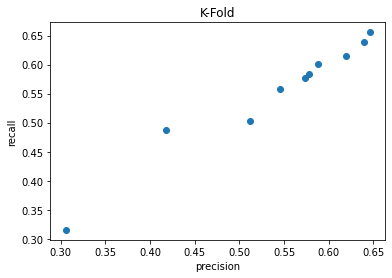

min precision: 0.30543822409545335
min recall: 0.3152236467236467
max precision: 0.6461674048981978
max recall: 0.6556721617708867
average precision: 0.5425624609106428 sd= 0.10145282037729228
average recall: 0.553384324783155 sd= 0.09435174789195694


In [19]:
res = np.array(results)

prec = res[:,0]
print(prec)
recl = res[:,1]
print(recl)

plt.scatter(prec, recl)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('K-Fold') 
plt.show()

print('min precision:', prec.min())
print('min recall:', recl.min())
print('max precision:', prec.max())
print('max recall:', recl.max())
print('average precision:', prec.mean(), 'sd=', prec.std())
print('average recall:', recl.mean(),'sd=', recl.std())

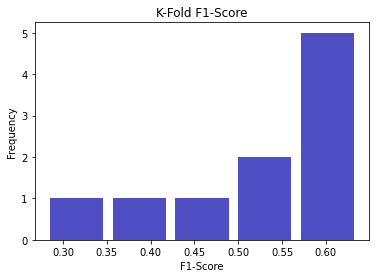

F1-Score: 0.5283852393417194 sd= 0.10523668823561988


In [20]:
res = np.array(results)
f1_score = res[:,2]
plt.hist(x=f1_score, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title('K-Fold F1-Score') 
plt.ylabel('Frequency') 
plt.xlabel('F1-Score') 
plt.show()
print('F1-Score:', f1_score.mean(), 'sd=', f1_score.std())

res_model1 = res

array([[0.41809579, 0.4864899 , 0.4107264 ],
       [0.63930066, 0.63849689, 0.63775257],
       [0.57366418, 0.57663869, 0.54164815],
       [0.6461674 , 0.65567216, 0.63298972],
       [0.58781498, 0.60119537, 0.57438299],
       [0.57785259, 0.58368895, 0.5662181 ],
       [0.54565741, 0.55767051, 0.53416549],
       [0.61949644, 0.61544074, 0.6127118 ],
       [0.51213693, 0.50332639, 0.49373457],
       [0.30543822, 0.31522365, 0.27952259]])